In [224]:
import scanpy as sc
import numpy as np
import torch
import pandas as pd
import os
import stadiffuser.utils as stutils
import importlib
from stadiffuser import pipeline, metrics
from diffusers import DDPMScheduler
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import rdata

warnings.filterwarnings("ignore")
os.environ["R_HOME"] = r"D:\Program Files\R\R-4.0.3"

def read_simRDS(path, ref_adata=None):
    res =  rdata.parser.parse_file(path)
    res = rdata.conversion.convert(res)
    if ref_adata is not None:
        sim_adata = ref_adata.copy()
        sim_adata.obs["labels"] = res["sim_labels"]
        sim_adata.obsm["spatial"] = np.array(res["sim_spatial"])
        sim_adata.X = res["sim_count"].T
        return sim_adata
    else:
        return res


def read_adata_list(path, name, n_rep, ref_data=None):
    adata_list = []
    for i in range(1, 1 + n_rep):
        adata_sim = read_simRDS(path + name.format(i), ref_adata=ref_data)
        adata_list.append(adata_sim)
    return adata_list

def get_recon(adata, autoencoder, device="cuda:0", use_net="spatial_net", apply_normalize=True, use_rep="latent"):
    adata_recon = adata.copy()
    if apply_normalize:
        sc.pp.normalize_total(adata_recon, target_sum=1e4)
        sc.pp.log1p(adata_recon)
    data = pipeline.prepare_dataset(adata_recon, use_net=use_net, use_spatial="spatial")
    autoencoder = autoencoder.to(device)
    data = data.to(device)
    autoencoder.eval()
    with torch.no_grad():
        latent, recon = autoencoder(data.x, data.edge_index)
    adata_recon.X = recon.cpu().numpy()
    adata_recon.obsm[use_rep] = latent.cpu().numpy()
    return adata_recon

DLPFC_DIR = "E:\Datasets\DLPFC"
FIGURE_DIR = "../output/App1-DLPFC/151676/_figures"
device = torch.device("cuda:0")
inch_to_cm = 2.54
method_palette = {
    'splatter': {'marker': 's', 'color': '#1f78b4'},  # Blue
    'kersplatter': {'marker': 's', 'color': '#a6cee3'},  # Lighter blue
    'zinb': {'marker': '^', 'color': '#ff7f00'},  # Orange
    'zinb_spatial': {'marker': 'v', 'color': '#fdbf6f'},  # Lighter orange
    'SRT_domain': {'marker': 's', 'color': '#33a02c'},  # Green
    'stadiff': {'marker': '*', 'color': '#e31a1c'},  # Red
    'scDesign': {'marker': 'o', 'color': '#6a3d9a'},  # Purple
}

# Load raw data and set global variables

In [217]:
# Set global variables and load data

#  set device
sim_names = ["splatter", "zinb", "zinb_spatial", "scDesign", "SRT_domain", "SRT_tissue", ]
n_rep = 5
adata_raw = sc.read_h5ad("../output/App1-DLPFC/151676/151676_raw.h5ad")
adata = sc.read_h5ad("../output/App1-DLPFC/151676/151676_processed.h5ad")
adata_raw.X = adata_raw.X.toarray()

AnnData object with n_obs × n_vars = 3431 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'spatial', 'spatial_net'
    obsm: 'spatial'

In [219]:
# remove na labels in obs `ground_truth"
adata = adata[~adata.obs["ground_truth"].isna(), :]
adata

View of AnnData object with n_obs × n_vars = 3431 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'spatial', 'spatial_net'
    obsm: 'spatial'

In [220]:
# compute the spatial net
adata = stutils.cal_spatial_net2D(adata, rad_cutoff=150, add_key="spatial_net")

------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 19966 edges, 3431 cells, 5.8193 neighbors per cell on average.


# Benchmark the simulation performance on full data (slice 151676)

In [6]:
import itertools
importlib.reload(metrics)


def compute_sim_perf(sim_adata_list, autoencoder, adata_raw, adata_real_recon,
                     enhanced = False,
                     n_rep=5,
                     device="cuda:0"):
    sim_perf = dict()
    metric_names = ["cell_corr", "enhanced_cell_corr", "pairwise_cell_corr", "pairwise_enhanced_cell_corr"]
    metric_names += ["gene_corr", "enhanced_gene_corr", "pairwise_gene_corr", "pairwise_enhanced_gene_corr"]
    for name in metric_names:
        sim_perf[name] = []
    if not enhanced:
        adata_sim_recon_list = []
    else:
        adata_sim_recon_list = sim_adata_list
    for ind in range(n_rep):
        adata_sim = sim_adata_list[ind]
        if not enhanced:
            adata_sim_recon = get_recon(adata_sim, autoencoder, device=device, use_net="spatial_net")
            adata_sim_recon_list.append(adata_sim_recon)
        else:
            adata_sim_recon = adata_sim
        for dim in ["cell", "gene"]:
            sim_perf[dim + "_corr"].append(np.nanmean(metrics.compute_corr(adata_sim, adata_raw, dim=dim)))
            sim_perf["enhanced_" + dim + "_corr"].append(np.nanmean(metrics.compute_corr(adata_sim_recon, adata_real_recon, dim=dim)))

    for (i, j) in itertools.combinations(range(n_rep), 2):
        for dim in ["cell", "gene"]:
            sim_perf["pairwise_" + dim + "_corr"].append(np.nanmean(metrics.compute_corr(sim_adata_list[i], sim_adata_list[j], dim=dim)))
            sim_perf["pairwise_enhanced_" + dim + "_corr"].append(np.nanmean(metrics.compute_corr(adata_sim_recon_list[i], adata_sim_recon_list[j], dim=dim)))
    return sim_perf

In [7]:
adata_mask = sc.read_h5ad("../output/App1-DLPFC/151676/151676_mask.h5ad")
adata_mask

AnnData object with n_obs × n_vars = 3460 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'circle-1', 'circle-2', 'circle-3', 'rectangle-1', 'rectangle-2', 'rectangle-3', 'extrapolation-1', 'extrapolation-2', 'extrapolation-3', 'random_0.05', 'random_0.1', 'random_0.2', 'random_0.3', 'random_0.4', 'random_0.5', 'random_0.6', 'random_0.8', 'random_0.9', 'strip'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'spatial', 'spatial_net'
    obsm: 'spatial'

## Load simulated data and compute the performance

In [222]:
# load sim data list
full_sim_path = "E:\\Projects\\diffusion\\output\\App1-DLPFC\\151676\\full_sim\\"
adata.obsm["new_spatial"] = stutils.quantize_coordination(adata.obsm["spatial"], methods=[("division", 125), ("division", 125)])
autoencoder = torch.load("../output/App1-DLPFC/151676/full/autoencoder_attn2.pth")
denoiser = torch.load("../output/App1-DLPFC/151676/no-mask/denoiser.pth")
denoiser_label = torch.load("../output/App1-DLPFC/151676/no-mask/denoiser_ground_truth.pth")
data = pipeline.prepare_dataset(adata, use_net="spatial_net", use_spatial="new_spatial")
adata = pipeline.get_latent_embedding(adata, autoencoder, data, device=device)
normalizer = stutils.MinMaxNormalize(adata.obsm["latent"], dim=0)
# adata real recon
adata_real_recon = get_recon(adata, autoencoder, device=device, use_net="spatial_net", apply_normalize=False)

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.008, mean deviation: 0.2500588749635675, pearson correlation: 0.9998508764938737
Quantize 1th dimension of spatial coordinates to 0.008, mean deviation: 0.25002856310113675, pearson correlation: 0.9998722429659386


403.0

In [184]:
# simulate from stadiffuer
for i in range(1, 1 + n_rep):
    stadiff_sim = pipeline.simulate(denoiser, autoencoder, device=device, use_net="spatial_net",
                                    ref_data=adata, spatial_coord=adata.obsm["new_spatial"],
                                    seed=i, normarlizer=normalizer)
    break
    stadiff_sim.write_h5ad(full_sim_path + "stadiff_{}.h5ad".format(i))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [196]:
importlib.reload(pipeline)
sim_latent = pipeline.simulate(denoiser, device=device, use_net="spatial_net", ref_data=None,
                               spatial_coord=adata.obsm["new_spatial"], seed=2024)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [199]:
sim_latent = sim_latent.detach().cpu().numpy()
normalizer.denormalize(sim_latent).max(), normalizer.denormalize(sim_latent).min()

(3.0239537909210963, -3.0930489566295645)

In [204]:
X_recon = autoencoder.decode(torch.from_numpy(sim_latent).to(device), data.edge_index)

In [205]:
X_recon = X_recon.detach().cpu().numpy()

In [206]:
sim_adata = adata.copy()
sim_adata.X = X_recon

array([ 0.26284456, -0.5597503 , -0.49610973, ...,  0.35745697,
       -0.06025799, -0.22534061])

In [185]:
adata_real_recon.obsm["latent"].max(), adata_real_recon.obsm["latent"].min()

(3.0615213, -3.1469648)

In [192]:
normalizer.denormalize(sim_latent).max(), normalizer.denormalize(sim_latent).min()

AnnData object with n_obs × n_vars = 3431 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'spatial', 'spatial_net', 'edge_list'
    obsm: 'spatial', 'new_spatial', 'latent'

In [89]:
cond_name = "ground_truth"
num_class_embeds = len(np.unique(adata.obs[cond_name]))
class_dict = dict(zip(np.unique(adata.obs[cond_name]), range(num_class_embeds)))
print("Class encoding: ")
print(class_dict)
adata.obs["encoded_label"] = adata.obs[cond_name].map(class_dict)

Class encoding: 
{'Layer_1': 0, 'Layer_2': 1, 'Layer_3': 2, 'Layer_4': 3, 'Layer_5': 4, 'Layer_6': 5, 'WM': 6}


In [45]:
for i in range(1, 1 + n_rep):
    stadiff_sim = pipeline.simulate(denoiser_label, autoencoder, device=device, use_net="spatial_net",
                                    ref_data=adata, spatial_coord=adata.obsm["new_spatial"],
                                    labels = adata.obs["encoded_label"].to_numpy(),
                                    seed=i, normarlizer=normalizer)
    stadiff_sim.write_h5ad(full_sim_path + "stadiff_label_{}.h5ad".format(i))

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

In [167]:
stadiff_sim = [sc.read_h5ad(full_sim_path + "stadiff_{}.h5ad".format(i+1)) for i in range(n_rep)]
np.linalg.norm(stadiff_sim[0].X - stadiff_sim[1].X)

15.472294

<Axes: title={'center': 'ground_truth'}, xlabel='UMAP1', ylabel='UMAP2'>

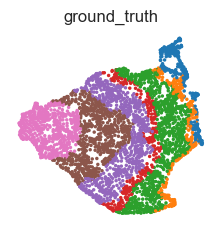

In [91]:
# plot latent umap
sc.pp.neighbors(adata, use_rep="latent", n_neighbors=30)
sc.tl.umap(adata)
fig, ax = plt.subplots(figsize=(2.6, 2.5))
sc.pl.umap(adata, color="ground_truth", ax=ax, show=False, frameon=False, legend_loc=None, size=25)

In [ ]:
# plot real umap


In [74]:
stadiff_sim_label = [sc.read_h5ad(full_sim_path + "stadiff_label_{}.h5ad".format(i+1)) for i in range(n_rep)]
np.linalg.norm(stadiff_sim_label[0].X - stadiff_sim_label[1].X)

25.379522

In [20]:
remain_indices = adata_raw.obs["ground_truth"].notna().values

In [21]:
# compute mean and omit nan
comp_sim_dict = dict()
n_rep = 5
sim_names = ["splatter", "kersplatter", "zinb_spatial", "scDesign", "SRT_domain"]
for method_name in sim_names:
    comp_sim_dict[method_name] = read_adata_list(full_sim_path, method_name + ("_{}.rds"),
                                                 n_rep, ref_data=adata_raw)

# load stadiffusion simulated data

In [52]:
gene_corr = dict()
for sim_name in comp_sim_dict:
    sim_adata = comp_sim_dict[sim_name][0][remain_indices, :]
    sim_adata.uns["spatial_net"] = adata.uns["spatial_net"]
    sim_adata_recon = get_recon(sim_adata, autoencoder, device=device, use_net="spatial_net")
    gene_corr[sim_name] = metrics.compute_corr(sim_adata_recon, adata_real_recon, dim="gene")
gene_corr["stadiff"] = metrics.compute_corr(stadiff_sim[0], adata_real_recon, dim="gene")

In [84]:
adata_real_recon

AnnData object with n_obs × n_vars = 3431 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'encoded_label'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'spatial', 'spatial_net', 'edge_list'
    obsm: 'spatial', 'new_spatial', 'latent'

In [77]:
adata_real_recon = get_recon(adata, autoencoder, device=device, use_net="spatial_net", apply_normalize=False)

<Axes: title={'center': 'ground_truth'}, xlabel='UMAP1', ylabel='UMAP2'>

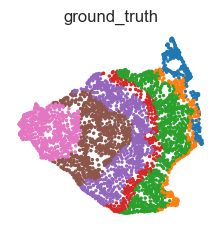

In [93]:
# plot umap of real data
fig, ax = plt.subplots(figsize=(2.6, 2.5))
sc.pp.neighbors(adata_real_recon, use_rep="latent", n_neighbors=30)
sc.tl.umap(adata_real_recon)
sc.pl.umap(adata_real_recon, color="ground_truth", ax=ax, show=False, frameon=False, legend_loc=None, size=25)

In [194]:
sim_adata = stadiff_sim

In [117]:
sim_adata = get_recon(sim_adata, autoencoder, device=device, use_net="spatial_net", apply_normalize=False)

In [195]:
gene_corr["stadiff"] = metrics.compute_corr(sim_adata, adata_real_recon, dim="gene")
gene_corr["stadiff"]

array([ 0.3034492 , -0.58075859, -0.46371438, ...,  0.58706051,
       -0.0188704 , -0.1864975 ])

In [173]:
x = sim_adata.X[0, :]
y = adata_real_recon.X[0, :]
# compute correlation
np.corrcoef(x, y)

array([[1.        , 0.95970814],
       [0.95970814, 1.        ]])

In [125]:
adata_real_recon.obsm["latent"].max(), sim_adata.obsm["latent"].min()

(3.2525501, -2.4415026)

(6.4071021626158995, -2.4415026)

In [96]:
adata_real_recon.X.max(), stadiff_sim[3].X.max()

(5.975626, 6.325469)

In [122]:
gene_corr["stadiff"]

array([-0.17722985,  0.10598821,  0.11644799, ..., -0.0541723 ,
        0.12435574,  0.09753086])

KeyError: 'SRT_tissue'

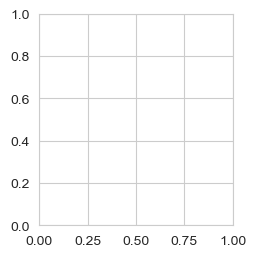

In [209]:
# plot violin plot
gene_corr_df = pd.DataFrame(gene_corr)
gene_corr_df = pd.melt(gene_corr_df, var_name="method", value_name="gene_corr")
fig, ax = plt.subplots(figsize=(2.5, 2.75))
# plot violin plot
violin_palette = [method_palette[name]["color"] for name in sim_names + ["stadiff"]]
sns.boxplot(data=gene_corr_df, x="method", y="gene_corr", ax=ax, palette=violin_palette)
# rotate xticklabels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# save to disk
plt.tight_layout()
fig.savefig(os.path.join(FIGURE_DIR, "full_sim", "gene_corr_boxplot.png"), dpi=600)

In [336]:
comp_perf_dict = dict()
for sim_name in sim_names:
    print("==== {} ====".format(sim_name))
    comp_perf_dict[sim_name] = compute_sim_perf(comp_sim_dict[sim_name], autoencoder, adata_raw, adata_real_recon,
                                 enhanced=False, n_rep=5, device=device)

==== splatter ====
==== kersplatter ====
==== zinb_spatial ====
==== scDesign ====
==== SRT_domain ====


In [337]:
comp_perf_dict["stadiff"] = compute_sim_perf(stadiff_sim, autoencoder, adata_raw, adata_real_recon,
                                enhanced=True, n_rep=n_rep, device=device)

{'splatter': {'cell_corr': [-0.003399822122771274,
   -0.0038451154197368348,
   -0.004128750128801633,
   -0.002934215196698793,
   -0.002538697879156361],
  'enhanced_cell_corr': [0.8185105803355952,
   0.8734751147754448,
   0.8798570186430701,
   0.8288499388293177,
   0.868981977466962],
  'pairwise_cell_corr': [-0.006156555579304535,
   -0.00028377373863060527,
   -0.0040457689889495515,
   -0.002834620384117585,
   -0.0029394890692913383,
   -0.0028727576880409615,
   -0.0007752336368082952,
   -0.004009020201696172,
   -0.001514738434483305,
   -0.004031415759022451],
  'pairwise_enhanced_cell_corr': [0.8858584981014475,
   0.9008349199089002,
   0.8772026586491202,
   0.875997584976855,
   0.9560182218400133,
   0.9586720739542868,
   0.9670416709229505,
   0.9227967015223694,
   0.9595149951188884,
   0.9349615223521373],
  'gene_corr': [0.00021800909937199852,
   -0.0005590720862653255,
   -4.192696714287671e-05,
   -5.355423382970016e-05,
   9.462308647753705e-05],
  'enhan

In [211]:
adata_sim =

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [210]:
stadiff_perf = compute_sim_perf(stadiff_sim, autoencoder, adata_raw, adata_real_recon,
                                enhanced=True, n_rep=n_rep, device=device)
comp_perf_dict["stadiff"] = stadiff_perf

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 3460

In [357]:
# compute the dataframe of the performance. Row: method, Column: the mean of the performance
metric_names = ["cell_corr", "enhanced_cell_corr", "pairwise_cell_corr", "pairwise_enhanced_cell_corr"]
metric_names += ["gene_corr", "enhanced_gene_corr", "pairwise_gene_corr", "pairwise_enhanced_gene_corr"]
perf_df = []
for sim_name in sim_names:
    perf_df.append([np.nanmean(comp_perf_dict[sim_name][name]) for name in metric_names])
perf_df.append([np.nanmean(stadiff_perf[name]) for name in metric_names])

In [358]:
sns.set_style("ticks")
sns.set_context("paper")
perf_df = pd.DataFrame(perf_df, index=sim_names + ["stadiff"], columns=metric_names)
for group in ["cell", "gene"]:
    perf_df["enhanced_" + group + "_diversity"] = 1 - perf_df["pairwise_enhanced_" + group + "_corr"]
    perf_df[group + "_diversity"] = 1 - perf_df["pairwise_" + group + "_corr"]

In [359]:
perf_df

cell_corr  enhanced_cell_corr  pairwise_cell_corr  \
splatter      -0.003369            0.853935           -0.002946   
kersplatter   -0.002423            0.842660            0.006837   
zinb_spatial   0.865653            0.953051            0.857902   
scDesign       0.955697            0.963125            0.955176   
SRT_domain     0.997625            0.970603            0.996944   
stadiff        0.713347            0.999894            0.999938   

              pairwise_enhanced_cell_corr  gene_corr  enhanced_gene_corr  \
splatter                         0.923890  -0.000068            0.000637   
kersplatter                      0.901972   0.000024           -0.006568   
zinb_spatial                     0.993481   0.018356            0.306750   
scDesign                         0.998356   0.024847            0.565934   
SRT_domain                       0.999675   0.863881            0.723640   
stadiff                          0.999938   0.138445            0.994658   

              pairwise_gene_corr  pairwise_enhanced_gene_corr  \
splatter               -0.000043                    -0.005599   
kersplatter            -0.000023                    -0.004052   
zinb_spatial            0.023442                     0.707207   
scDesign                0.023742                     0.841386   
SRT_domain              0.808417                     0.989329   
stadiff                 0.996271                     0.996271   

              enhanced_cell_diversity  cell_diversity  \
splatter                     0.076110        1.002946   
kersplatter                  0.098028        0.993163   
zinb_spatial                 0.006519        0.142098   
scDesign                     0.001644        0.044824   
SRT_domain                   0.000325        0.003056   
stadiff                      0.000062        0.000062   

              enhanced_gene_diversity  gene_diversity  
splatter                     1.005599        1.000043  
kersplatter                  1.004052        1.000023  
zinb_spatial                 0.292793        0.976558  
scDesign                     0.158614        0.976258  
SRT_domain                   0.010671        0.191583  
stadiff                      0.003729        0.003729

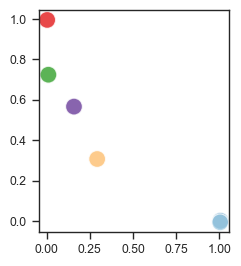

In [360]:
# omit splatter
#  the width of A4 paper is 8.27 inches
#
perf_df_drop = perf_df.drop("splatter")
perf_df_drop = perf_df.drop("kersplatter")

perf_df_drop["method"] = perf_df_drop.index
perf_df_drop = perf_df
fig, ax = plt.subplots(figsize=(2.5, 2.75))
# set color palette
sns.scatterplot(data=perf_df_drop, x="enhanced_gene_diversity", y="enhanced_gene_corr",
                hue=perf_df_drop.index,
                # style="method",
                ax=ax,
                palette=[method_palette[name]["color"] for name in perf_df_drop.index],
                markers="o",
                legend=False,
                s=150, alpha=0.8)
# ax.set_ylim(0.2, 1)
ax.set_xlabel("")
ax.set_ylabel("")
# set tick font size to 7
# save figure to file
plt.tight_layout()
# fig.savefig(os.path.join(FIGURE_DIR, "full_sim", "enhanced_gene_diversity_fidelity_gene.png"), dpi=600)

In [318]:
perf_df_drop

cell_corr  enhanced_cell_corr  pairwise_cell_corr  \
splatter      -0.003369            0.897939           -0.002946   
kersplatter   -0.002423            0.876258            0.006837   
zinb_spatial   0.865653            0.976226            0.857902   
scDesign       0.955697            0.987732            0.955176   
SRT_domain     0.997625            0.992582            0.996944   
stadiff        0.713347            0.999894            0.999938   

              pairwise_enhanced_cell_corr  gene_corr  enhanced_gene_corr  \
splatter                         0.947971  -0.000068           -0.011052   
kersplatter                      0.917824   0.000024           -0.006419   
zinb_spatial                     0.996455   0.018356            0.374096   
scDesign                         0.997866   0.024847            0.662015   
SRT_domain                       0.999498   0.863881            0.931431   
stadiff                          0.999938   0.138445            0.994658   

              pairwise_gene_corr  pairwise_enhanced_gene_corr  \
splatter               -0.000005                    -0.001626   
kersplatter             0.000005                     0.002980   
zinb_spatial            0.023442                     0.738371   
scDesign                0.023742                     0.836892   
SRT_domain              0.808417                     0.987664   
stadiff                 0.996271                     0.996271   

              enhanced_cell_diversity  cell_diversity  \
splatter                     0.052029        1.002946   
kersplatter                  0.082176        0.993163   
zinb_spatial                 0.003545        0.142098   
scDesign                     0.002134        0.044824   
SRT_domain                   0.000502        0.003056   
stadiff                      0.000062        0.000062   

              enhanced_gene_diversity  gene_diversity  
splatter                     1.001626        1.000005  
kersplatter                  0.997020        0.999995  
zinb_spatial                 0.261629        0.976558  
scDesign                     0.163108        0.976258  
SRT_domain                   0.012336        0.191583  
stadiff                      0.003729        0.003729

## Compute mLISI

In [ ]:
# compute mLISI
for sim_name in sim_names:
    print("==== {} ====".format(sim_name))
    comp_perf_dict[sim_name]["mLISI"] = []
    for i in range(n_rep):
        sim_data = get_recon(comp_sim_dict[sim_name][i], autoencoder, device=device, use_net="spatial_net")
        mlisi = metrics.compute_paired_lisi(sim_data, adata_real_recon)
        comp_perf_dict[sim_name]["mLISI"].append(mlisi.mean())
# compute mLISI for stadiff

In [18]:
stadiff_perf["mLISI"] = []
for i in range(n_rep):
    sim_data = stadiff_sim[i].copy()
    mlisi = metrics.compute_paired_lisi(sim_data, adata_real_recon)
    stadiff_perf["mLISI"].append(mlisi.mean())

In [20]:
stadiff_perf["mLISI"] = []
for i in range(n_rep):
    sim_data = stadiff_sim[i].copy()
    mlisi = metrics.compute_paired_lisi(sim_data, adata_real_recon)
    stadiff_perf["mLISI"].append(mlisi.mean())

In [21]:
# construct mLISI dataframe
mLISI_df = []
for sim_name in sim_names:
    for i in range(n_rep):
        mLISI_df.append([sim_name, comp_perf_dict[sim_name]["mLISI"][i]])
for i in range(n_rep):
    mLISI_df.append(["stadiff", stadiff_perf["mLISI"][i]])
mLISI_df = pd.DataFrame(mLISI_df, columns=["method", "mLISI"])

In [22]:
# compute them mean of mLISI
mLISI_df_mean = mLISI_df.groupby("method").mean().reset_index()
mLISI_df_mean

method     mLISI
0    SRT_domain  1.923053
1   kersplatter  1.130739
2      scDesign  1.548634
3      splatter  1.134018
4       stadiff  1.955956
5  zinb_spatial  1.157578

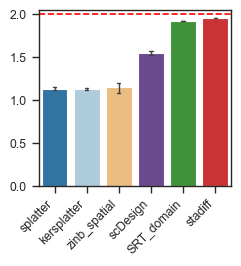

In [315]:
# plot barplot with error bar
fig, ax = plt.subplots(figsize=(2.5, 2.75))
sns.barplot(data=mLISI_df, x="method", y="mLISI", ax=ax,
            palette=[method_palette[name]["color"] for name in sim_names + ["stadiff"]],
            errwidth=1, capsize=0.1)
# rotate xticklabels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel("")
ax.set_ylabel("")
# add read vertical line
ax.axhline(y=2, color="red", linestyle="--")
plt.tight_layout()
# save to disk
fig.savefig(os.path.join(FIGURE_DIR, "full_sim", "mLISI.png"), dpi=600)

In [613]:
sim_recon_list = []
for i, sim_name in enumerate(sim_names):
    sim_data = get_recon(comp_sim_dict[sim_name][0], autoencoder, device=device, use_net="spatial_net")
    sim_recon_list.append(sim_data)
sim_recon_list += [stadiff_sim[0]]

In [767]:
stadiff_sim[0]

View of AnnData object with n_obs × n_vars = 1 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'mask'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'spatial', 'spatial_net', 'edge_list', 'neighbors', 'umap', 'ground_truth_colors'
    obsm: 'spatial', 'new_spatial', 'latent', 'X_umap'
    obsp: 'distances', 'connectivities'

[<Axes: title={'center': 'PCP4'}, xlabel='spatial1', ylabel='spatial2'>]

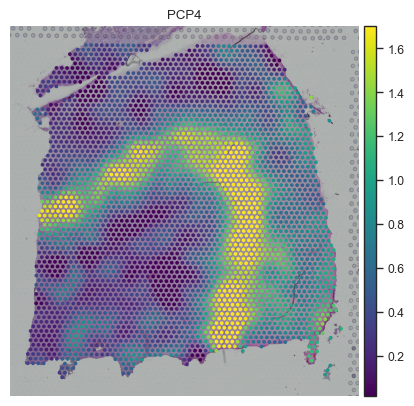

In [775]:
stadiff_sim.obsm = adata.obsm
sc.pl.spatial(stadiff_sim, color="PCP4", show=False, frameon=False, legend_loc=None,
                basis="spatial", cmap="viridis", vmin="p5", vmax="p95")

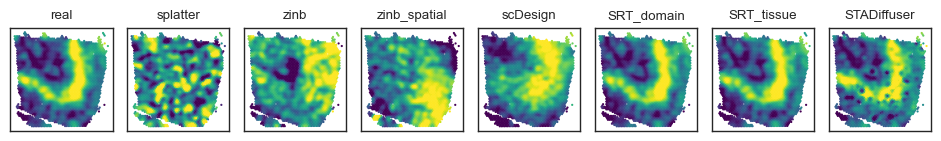

In [644]:
# plot the gene ecpression of the simulated data
plot_gene_name = "PCP4"
fig, axes = plt.subplots(1, 8, figsize=(9.5, 1.5), sharex=True, sharey=True)
for ind in range(len(sim_names)+1):
    if ind == 0:
        adata_temp = adata_real_recon
        name = "real"
    else:
        adata_temp = adata.copy()
        sim_data = sim_recon_list[ind-1]
        adata_temp = adata_raw.copy()
        adata_temp.X = sim_data.X
        name = sim_names[ind - 1]
    sc.pl.embedding(adata_temp, color=plot_gene_name, ax=axes[ind], show=False, legend_loc=None,
                  title=name, frameon=True, basis="spatial", cmap="viridis", size=10, vmin="p5", vmax="p95")
   # remove colorbar
    axes[ind].collections[0].colorbar.remove()
    axes[ind].set_xlabel("")
    axes[ind].set_ylabel("")
    if ind == 0:
        axes[ind].set_title("real")
    else:
        axes[ind].set_title(sim_names[ind-1])
    axes[ind].set_xticks([])
    axes[ind].set_yticks([])
plt.tight_layout()

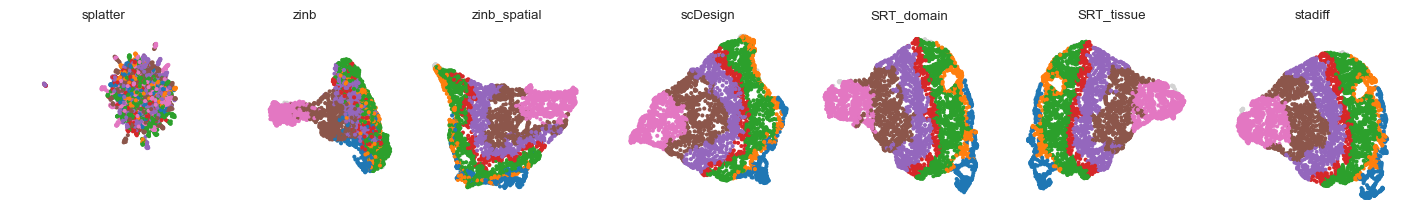

In [403]:
scale = 1.5
fig, axes = plt.subplots(1, 7, figsize=(9.5 * scale, 1.5 * scale), sharex=True, sharey=True)
# plot umap
for i, sim_name in enumerate(sim_names):
    sim_data = sim_recon_list[i]
    sc.pp.neighbors(sim_data, use_rep="latent", n_neighbors=30)
    sc.tl.umap(sim_data)
    # set frame off
    sc.pl.umap(sim_data, color="ground_truth", ax=axes[i], show=False, legend_loc=None,
               title=sim_name, frameon=False)
sim_data = stadiff_sim[0]
sc.pp.neighbors(sim_data, use_rep="latent", n_neighbors=30)
sc.tl.umap(sim_data)
sc.pl.umap(sim_data, color="ground_truth", ax=axes[6], show=False, legend_loc=None,
           title="stadiff", frameon=False)
plt.tight_layout()

In [413]:
for ind in range(len(sim_names)):
    # compute mLSI
    sim_mLISI = metrics.compute_paired_lisi(sim_recon_list[ind], adata_real_recon)
    print(sim_names[ind], sim_mLISI.mean())

splatter 1.1795987591830122
zinb 1.0832187449439488
zinb_spatial 1.253576977861239
scDesign 1.5317600986973294
SRT_domain 1.9446782857654956
SRT_tissue 1.946585553804036


In [368]:
# compute mLSI for stadiff
stadiff_mLISI = metrics.compute_paired_lisi(stadiff_sim[0], adata_real_recon)
# 2 decimal
print("stadiff: {:.2f}".format(stadiff_mLISI.mean()))

KeyboardInterrupt: 

# Benchmark the simulation performance on masked data

## Create mask

In [528]:
adata_mask

AnnData object with n_obs × n_vars = 1384 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'circle-1', 'circle-2', 'circle-3', 'rectangle-1', 'rectangle-2', 'rectangle-3', 'extrapolation-1', 'extrapolation-2', 'extrapolation-3', 'random_0.05', 'random_0.1', 'random_0.2', 'random_0.3', 'random_0.4', 'random_0.5', 'random_0.6', 'random_0.8', 'random_0.9', 'strip'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'spatial', 'spatial_net', 'ground_truth_colors', 'edge_list'
    obsm: 'spatial', 'new_spatial', 'latent'

In [572]:
adata_full.X.max()

6.6779027

--------------------
Remove 121 nodes and 802 edges from the original data
Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.008, mean deviation: 0.24999101527403414, pearson correlation: 0.9998564166978975
Quantize 1th dimension of spatial coordinates to 0.008, mean deviation: 0.2499598682240192, pearson correlation: 0.999875750266831
Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.008, mean deviation: 0.24996994219653185, pearson correlation: 0.9998530001087567
Quantize 1th dimension of spatial coordinates to 0.008, mean deviation: 0.25000231213872837, pearson correlation: 0.9998739961836521


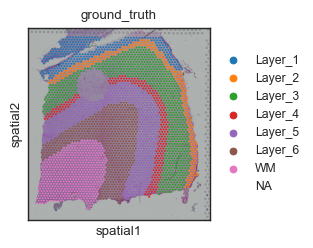

In [598]:
from scripts.App1_DLPFC import mask_region
adata_full = sc.read_h5ad("../output/App1-DLPFC/151676/151676_processed.h5ad")
adata_full.X = adata_full.X.toarray()
use_mask = "circle-1"
adata_mask = sc.read_h5ad("../output/App1-DLPFC/151676/151676_mask.h5ad")
adata_full.obs["mask"] = adata_mask.obs[use_mask]
adata_mask = mask_region(adata_mask, use_mask)
# adata_mask.write_h5ad("../output/App1-DLPFC/151676/151676_mask.h5ad")
fig, ax = plt.subplots(figsize=(2.5, 2.5))
sc.pl.spatial(adata_mask, color="ground_truth", ax=ax, show=False)
# save to disk
fig.savefig(os.path.join(FIGURE_DIR, "mask_observed_{}.png".format(use_mask)), dpi=600)
adata_mask.obsm["new_spatial"] = stutils.quantize_coordination(adata_mask.obsm["spatial"],
                                                                 methods=[("division", 125), ("division", 125)])
adata_full.obsm["new_spatial"] = stutils.quantize_coordination(adata_full.obsm["spatial"],
                                                                 methods=[("division", 125), ("division", 125)])
autoencoder_full = torch.load("../output/App1-DLPFC/151676/no-mask/autoencoder_attn2.pth")
denoiser = torch.load("../output/App1-DLPFC/151676/{}/denoiser.pth".format(use_mask))
data_full = pipeline.prepare_dataset(adata_full, use_net="spatial_net", use_spatial="spatial")
data = pipeline.prepare_dataset(adata_mask, use_net="spatial_net", use_spatial="spatial")
adata_mask = pipeline.get_latent_embedding(adata_mask, autoencoder, data, device=device)
normalizer = stutils.MinMaxNormalize(adata_mask.obsm["latent"], dim=0)
adata_real_recon = get_recon(adata_full, autoencoder_full, device=device, use_net="spatial_net", apply_normalize=False)

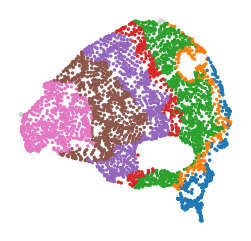

In [599]:
adata_mask_recon = get_recon(adata_mask, autoencoder, device=device, use_net="spatial_net", apply_normalize=False)
# perform umap
sc.pp.neighbors(adata_mask_recon, use_rep="latent", n_neighbors=30)
sc.tl.umap(adata_mask_recon)
fig, ax = plt.subplots(figsize=(2.6, 2.5))
sc.pl.umap(adata_mask_recon, color="ground_truth", ax=ax, show=False, frameon=False, legend_loc=None, size=25)
ax.set_title("")
ax.set_xlabel("")
ax.set_ylabel("")
plt.tight_layout()
# save fig to
fig.savefig(os.path.join(FIGURE_DIR, "umap_mask_{}.png".format(use_mask)), dpi=600)

In [600]:
stadiff_sim = pipeline.simulate(denoiser, autoencoder, device=device, use_net="spatial_net", normalizer=normalizer,
                                ref_data=adata_full, spatial_coord=adata_full.obsm["new_spatial"], seed=2024)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [601]:
# load sim data
comp_names = ["SRTSim_fill_inplace"]
comp_sim_dict = dict()
for comp_name in comp_names:
    comp_sim_dict[comp_name] = read_adata_list("../output/App1-DLPFC/151676/{}/".format(use_mask), comp_name + "{}.rds",
                                               3, ref_data=adata_full)

In [581]:
srtt_sim = comp_sim_dict["SRTSim_fill_inplace"][2]
srtt_sim_recon = get_recon(srtt_sim, autoencoder, device=device, use_net="spatial_net")
imputed = np.logical_not(adata_full.obs["mask"].to_numpy()).astype(bool)

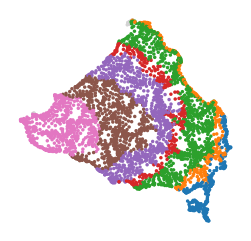

In [582]:
# plot umap for srtsim
sc.pp.neighbors(srtt_sim_recon, use_rep="latent", n_neighbors=30)
sc.tl.umap(srtt_sim_recon)
fig, ax = plt.subplots(figsize=(2.6, 2.5))
sc.pl.umap(srtt_sim_recon, color="ground_truth", ax=ax, show=False, frameon=False, legend_loc=None, size=25)
ax.set_title("")
ax.set_xlabel("")
ax.set_ylabel("")
plt.tight_layout()
# save fig to
fig.savefig(os.path.join(FIGURE_DIR, "umap_srttsim_{}.png".format(use_mask)), dpi=600)

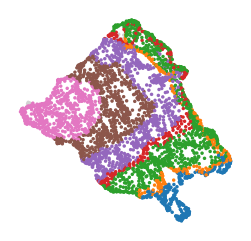

In [583]:
# plot umap for stadiffuser
sc.pp.neighbors(stadiff_sim, use_rep="latent", n_neighbors=30)
sc.tl.umap(stadiff_sim)
fig, ax = plt.subplots(figsize=(2.6, 2.5))
sc.pl.umap(stadiff_sim, color="ground_truth", ax=ax, show=False, frameon=False, legend_loc=None, size=25)
ax.set_title("")
ax.set_xlabel("")
ax.set_ylabel("")
plt.tight_layout()
# save fig to
fig.savefig(os.path.join(FIGURE_DIR, "umap_stadiff_{}.png".format(use_mask)), dpi=600)

In [470]:
# compute mLSI
srtt_mLISI = metrics.compute_paired_lisi(srtt_sim_recon, adata_real_recon)
stadiff_mLISI = metrics.compute_paired_lisi(stadiff_sim, adata_real_recon)
print("use_mask = \"{}\"".format(use_mask))
print("SRTSim: {:.2f}({:.2f})".format(srtt_mLISI.mean(), srtt_mLISI.std()))
print("STADiffuser: {:.2f}({:.2f})".format(stadiff_mLISI.mean(), stadiff_mLISI.std()))

use_mask = "random_0.4"
SRTSim: 1.69(0.32)
STADiffuser: 1.93(0.09)


use_mask = "random_0.05"
SRTSim(t): 1.64(0.34)
STADiffuser: 1.96(0.04)
use_mask = "random_0.1"
SRTSim(t): 1.91(0.13)
STADiffuser: 1.95(0.05)



In [584]:

# compute the mean gene expression in the imputed region
adata_full_raw = sc.read_h5ad("../output/App1-DLPFC/151676/151676_raw.h5ad")
adata_full_raw.X = adata_full_raw.X.toarray()
corr_df = dict()
corr_df["SRTSim"] = metrics.compute_corr(srtt_sim_recon[imputed,:], adata_real_recon[imputed, :], dim="gene")
corr_df["STADiffuser"] = metrics.compute_corr(stadiff_sim[imputed, :], adata_real_recon[imputed, :], dim="gene")
corr_df = pd.DataFrame(corr_df)
corr_df["type"] = "Imputed"
corr_df_ = dict()
corr_df_["SRTSim"] = metrics.compute_corr(srtt_sim_recon[~imputed, :], adata_real_recon[~imputed, :], dim="gene")
corr_df_["STADiffuser"] = metrics.compute_corr(stadiff_sim[~imputed, :], adata_real_recon[~imputed, :], dim="gene")
corr_df_ = pd.DataFrame(corr_df_)
# add one column
corr_df_["type"] = "Observed"
corr_df = pd.concat([corr_df, corr_df_])
# metl the dataframe
corr_df = pd.melt(corr_df, id_vars="type", value_vars=["SRTSim", "STADiffuser"], var_name="method", value_name="corr")

In [585]:
# compute mean and std group by type and method
corr_df_mean = corr_df.groupby(["type", "method"]).mean()
# save to disk
corr_df_mean.to_csv(os.path.join(FIGURE_DIR, "{}_imputed_corr_mean.csv".format(use_mask)))
# compute std group by type and method
corr_df_std = corr_df.groupby(["type", "method"]).std()
# save to disk
corr_df_std.to_csv(os.path.join(FIGURE_DIR, "{}_imputed_corr_std.csv".format(use_mask)))
print(corr_df_mean)
print(corr_df_std)

                          corr
type     method               
Imputed  SRTSim       0.527568
         STADiffuser  0.112302
Observed SRTSim       0.734561
         STADiffuser  0.112280
                          corr
type     method               
Imputed  SRTSim       0.294766
         STADiffuser  0.393945
Observed SRTSim       0.148439
         STADiffuser  0.301691


In [588]:
missing_rate = [0.1, 0.2, 0.3, 0.4, 0.5]
# read the result and plot missing_rate vs. corr
df_full = pd.DataFrame()
for r in missing_rate:
    print("use_mask = \"random_{}\"".format(r))
    corr_df_mean = pd.read_csv(os.path.join(FIGURE_DIR, "random_{}_imputed_corr_mean.csv".format(r)))
    corr_df_mean["missing_rate"] = r
    df_full = pd.concat([df_full, corr_df_mean])
df_full

use_mask = "random_0.1"
use_mask = "random_0.2"
use_mask = "random_0.3"
use_mask = "random_0.4"
use_mask = "random_0.5"


type       method      corr  missing_rate
0   Imputed       SRTSim  0.882497           0.1
1   Imputed  STADiffuser  0.883458           0.1
2  Observed       SRTSim  0.896151           0.1
3  Observed  STADiffuser  0.905939           0.1
0   Imputed       SRTSim  0.871140           0.2
1   Imputed  STADiffuser  0.900748           0.2
2  Observed       SRTSim  0.879572           0.2
3  Observed  STADiffuser  0.917944           0.2
0   Imputed       SRTSim  0.884375           0.3
1   Imputed  STADiffuser  0.896193           0.3
2  Observed       SRTSim  0.901336           0.3
3  Observed  STADiffuser  0.921113           0.3
0   Imputed       SRTSim  0.820315           0.4
1   Imputed  STADiffuser  0.842975           0.4
2  Observed       SRTSim  0.825587           0.4
3  Observed  STADiffuser  0.859711           0.4
0   Imputed       SRTSim  0.845989           0.5
1   Imputed  STADiffuser  0.839099           0.5
2  Observed       SRTSim  0.869272           0.5
3  Observed  STADiffuser  0.879023           0.5

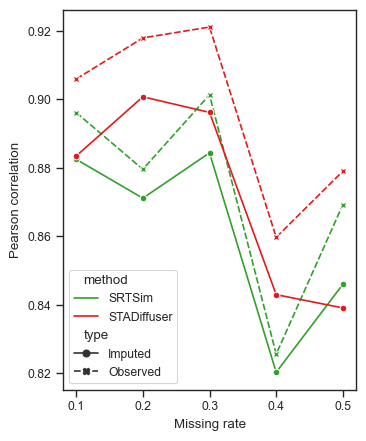

In [596]:
# plot line plot for missing_rate vs. corr group by method and type
fig, ax = plt.subplots(figsize=(3.75, 4.5))
sns.lineplot(data=df_full, x="missing_rate", y="corr", hue="method", style="type", ax=ax,
             palette=[method_palette[name]["color"] for name in ["SRT_domain", "stadiff"]],
             markers=True, err_style="bars", ci=95)
ax.set(xlabel="Missing rate", ylabel="Pearson correlation")
plt.tight_layout()

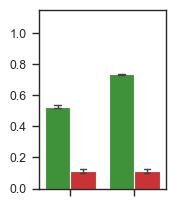

In [586]:
# plot violin plot
import matplotlib
plot_names = ["SRTSim", "STADiffuser"]
fig, ax = plt.subplots(figsize=(1.85, 2.15))
# set style
sns.set_style("ticks")
sns.set_context("paper")
# plot barplot without legend
sns.barplot(data=corr_df, ax=ax,
            y = "corr", hue = "method",
            x = "type",
            palette=[method_palette[name]["color"] for name in ["SRT_domain", "stadiff"]],
            errwidth=1, capsize=0.1, ci=95)
# remove legend
ax.set_ylim([0, 1.15])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
ax.legend_.remove()
plt.tight_layout()
# save to disk
fig.savefig(os.path.join(FIGURE_DIR, "{}_imputed_corr.png".format(use_mask)), dpi=600)

## De novo generation

In [167]:
# compute the spatial_old coordinate using x_max, y_max, x_min, y_min
# spatial_new = (spatial_old - (x_min, y_min)) / (x_max - x_min, y_max - y_min)
spatial_new = srtt_sim.obsm["sim_spatial"]
spatial_old = spatial_new * (x_max - x_min, y_max - y_min) + (x_min, y_min)
srtt_sim.obsm["spatial"] = spatial_old

In [170]:
srtt_sim = get_recon(srtt_sim, autoencoder, device=device, use_net="spatial_net")

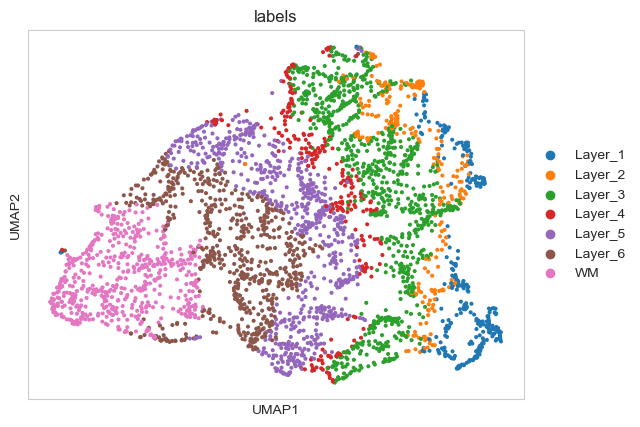

In [171]:
#perform umap on srtt_sim
sc.pp.neighbors(srtt_sim, use_rep="latent", n_neighbors=30)
sc.tl.umap(srtt_sim)
sc.pl.umap(srtt_sim, color="labels")

In [172]:
sim_spatial_new = stutils.quantize_coordination(srtt_sim.obsm["spatial"], methods=[("division", 125), ("division", 125)])

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.008, mean deviation: 0.2503106410478196, pearson correlation: 0.9998302119145048
Quantize 1th dimension of spatial coordinates to 0.008, mean deviation: 0.24662118081860726, pearson correlation: 0.9998731023384918


In [173]:
importlib.reload(pipeline)
stadiff_sim = pipeline.simulate(denoiser, autoencoder, device=device, use_net="spatial_net",
                                ref_data=srtt_sim, spatial_coord=sim_spatial_new, seed=0, normarlizer=normalizer)

  0%|          | 0/1000 [00:00<?, ?it/s]

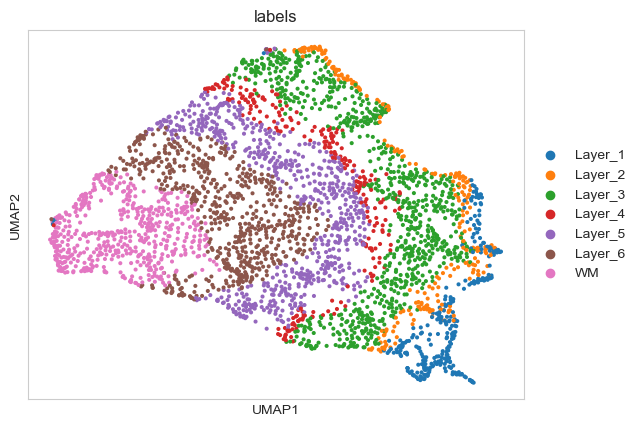

In [174]:
# perform umap on stadiff_sim ["sim_emebd"]
sc.pp.neighbors(stadiff_sim, use_rep="sim_embed", n_neighbors=30)
# perform louvain clustering
sc.tl.umap(stadiff_sim)
sc.pl.embedding(stadiff_sim, basis="umap", color="labels")

In [176]:
from stadiffuser.analytics import mclust_R
stadiff_sim.obsm["sim_embed"].max()

3.4006503

In [177]:
stadiff_sim = mclust_R(stadiff_sim, 7, use_rep="sim_embed", add_key="mclust")

fitting ...
  |======================================================================| 100%


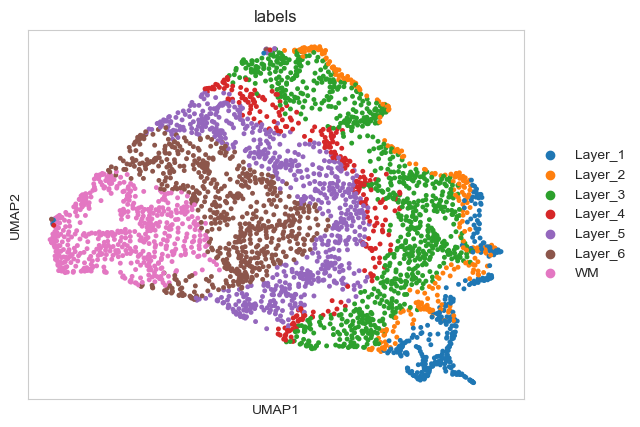

In [178]:
sc.pl.embedding(stadiff_sim, basis="umap", color="labels", size=50)

fitting ...
  |======================================================================| 100%


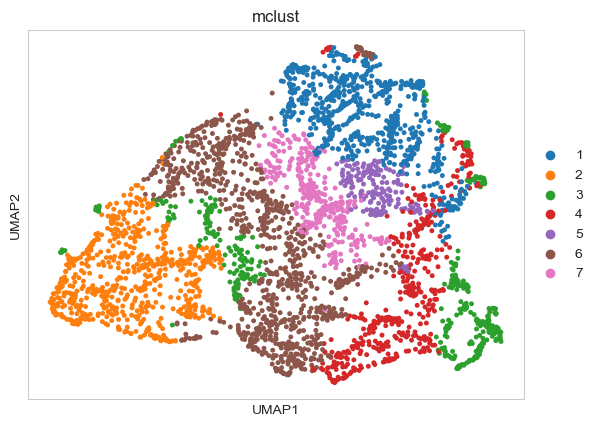

In [179]:
# perform mclus on srtt_sim
srtt_sim = mclust_R(srtt_sim, 7, use_rep="latent", add_key="mclust")
# visualize the result
sc.pl.embedding(srtt_sim, basis="umap", color="mclust", size=50)

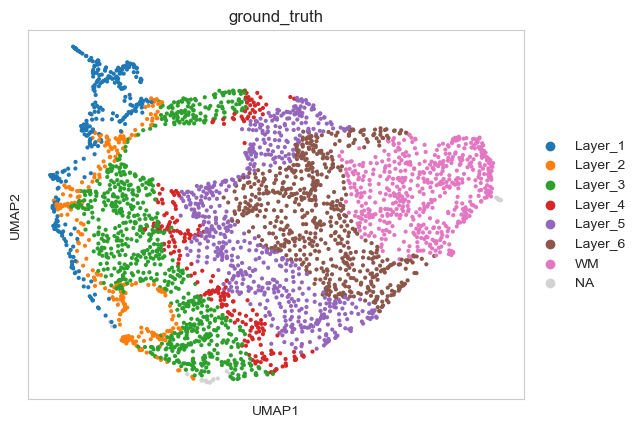

In [23]:
sc.pp.neighbors(stadiff_sim, use_rep="sim_embed", n_neighbors=30)
sc.tl.umap(stadiff_sim)
sc.pl.embedding(stadiff_sim, basis="umap", color="ground_truth")

In [143]:
adata = sc.read_h5ad("../output/App1-DLPFC/151676/151676_processed.h5ad")
adata.obsm["spatial_new"] = stutils.quantize_coordination(adata.obsm["spatial"], methods=[("division", 125), ("division", 125)])
adata

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.008, mean deviation: 0.24996994219653185, pearson correlation: 0.9998530001087567
Quantize 1th dimension of spatial coordinates to 0.008, mean deviation: 0.25000231213872837, pearson correlation: 0.9998739961836521


AnnData object with n_obs × n_vars = 3460 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'spatial', 'spatial_net'
    obsm: 'spatial', 'spatial_new'

In [145]:
data = pipeline.prepare_dataset(adata, use_net="spatial_net", use_spatial="spatial_new")
stadiff_sim_inplace = pipeline.simulate(denoiser, autoencoder, device=device, use_net="spatial_net",
                                ref_data=adata, spatial_coord=adata.obsm["spatial_new"], seed=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

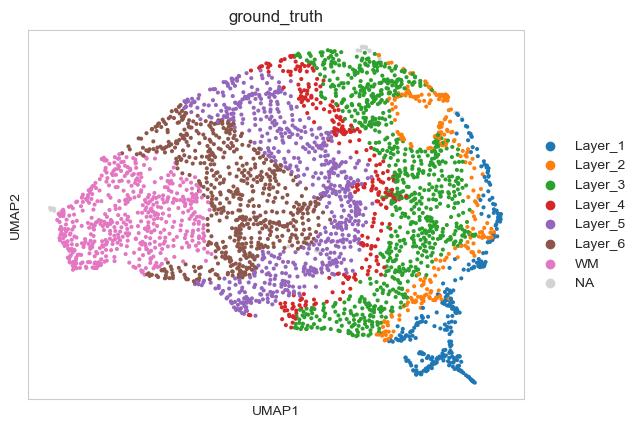

In [146]:
# perform umap
sc.pp.neighbors(stadiff_sim_inplace, use_rep="sim_embed", n_neighbors=30)
sc.tl.umap(stadiff_sim_inplace)
sc.pl.embedding(stadiff_sim_inplace, basis="umap", color="ground_truth")

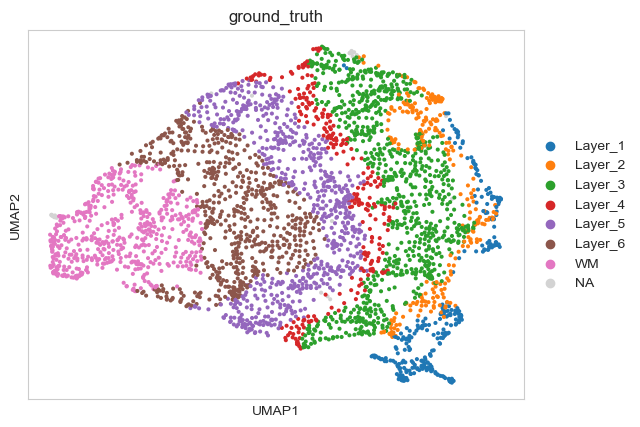

In [147]:
adata_real_recon = get_recon(adata, autoencoder, device=device, use_net="spatial_net")
# perform umap
sc.pp.neighbors(adata_real_recon, use_rep="latent", n_neighbors=30)
sc.tl.umap(adata_real_recon)
sc.pl.embedding(adata_real_recon, basis="umap", color="ground_truth")

#  Compare data generation with/ without layer information

# Layer redesign

In [81]:
from scripts.App1_DLPFC import load_slice_data
import numpy as np
from scipy.spatial.distance import cdist

def match_spatial(spatial_ref, spatial_target):
    """
    Match two spatial datasets to minimize the distance between corresponding points.
    Return the matched target spatial data.

    Parameters:
    - spatial_ref: numpy array of shape (n1, 2) representing reference spatial data
    - spatial_target: numpy array of shape (n2, 2) representing target spatial data

    Returns:
    - matched_indices: numpy array of shape (n1, ) representing the matched indices in target spatial data
    """
    # compute the distance matrix
    spatial_ref = spatial_ref - spatial_ref.min(axis=0)
    spatial_target = spatial_target - spatial_target.min(axis=0)
    # compute the distance matrix
    distance_matrix = cdist(spatial_ref, spatial_target)
    print(distance_matrix.shape)
    # find the best matching indices
    matched_indices = np.argmin(distance_matrix, axis=1)
    return matched_indices

ref_slice_id = "151676"
target_slice_id = "151670"
adata_ref,  adata_ref_raw = load_slice_data("151676", return_raw=True)
adata_target, adata_target_raw = load_slice_data(target_slice_id, return_raw=True)
# remove nan
adata_ref = adata_ref[~adata_ref.obs["ground_truth"].isna()]
adata_ref_raw = adata_ref_raw[~adata_ref_raw.obs["ground_truth"].isna()]
adata_target = adata_target[~adata_target.obs["ground_truth"].isna()]
adata_ref = stutils.cal_spatial_net2D(adata_ref, rad_cutoff=150, add_key="spatial_net", use_obsm="spatial")
adata_target = stutils.cal_spatial_net2D(adata_target, rad_cutoff=150, add_key="spatial_net", use_obsm="spatial")

------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 19966 edges, 3431 cells, 5.8193 neighbors per cell on average.
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 20340 edges, 3484 cells, 5.8381 neighbors per cell on average.


In [82]:
new_spaital = stutils.quantize_coordination(adata_ref.obsm["spatial"], methods=[("division", 125), ("division", 125)])
adata_ref.obsm["new_spatial"] = new_spaital

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.008, mean deviation: 0.2500588749635675, pearson correlation: 0.9998508764938737
Quantize 1th dimension of spatial coordinates to 0.008, mean deviation: 0.25002856310113675, pearson correlation: 0.9998722429659386


(3431, 3484)


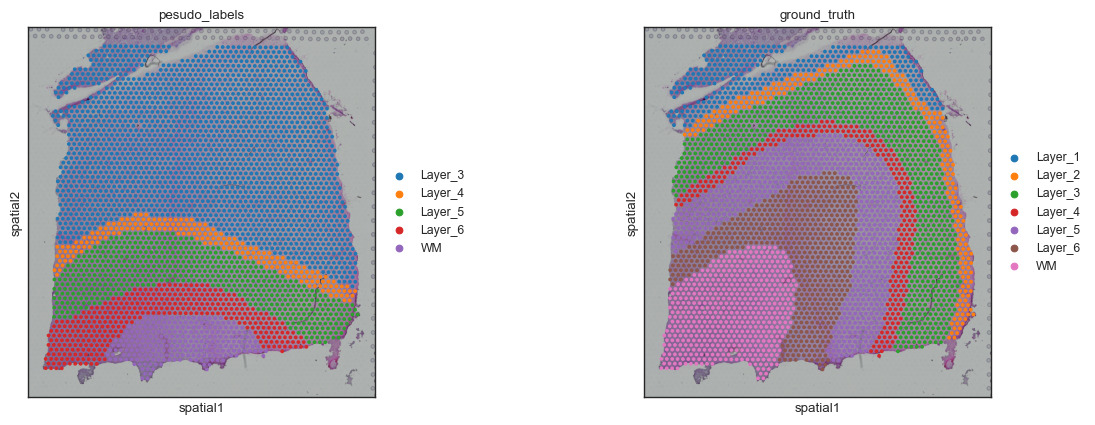

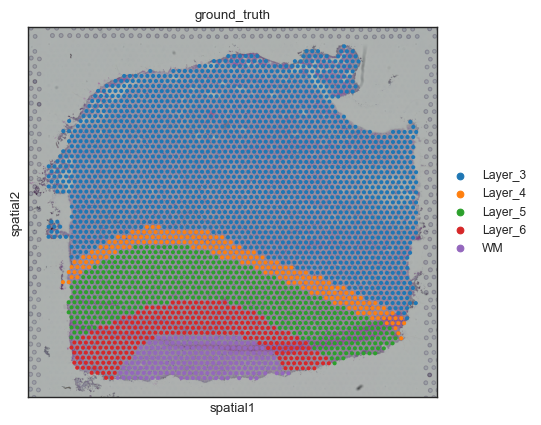

In [83]:
matched_indices = match_spatial(adata_ref.obsm["spatial"], adata_target.obsm["spatial"])
adata_ref.obs["pesudo_labels"] = adata_target.obs["ground_truth"].to_numpy()[matched_indices]
adata_ref_raw.obs["pesudo_labels"] = adata_target.obs["ground_truth"].to_numpy()[matched_indices]
sc.pl.spatial(adata_ref, color=["pesudo_labels", "ground_truth"])
sc.pl.spatial(adata_target, color="ground_truth")
adata_ref_raw.write_h5ad("../output/App1-DLPFC/151676/151676_target_151670.h5ad")

In [307]:
# sortedy by Layer_1 ..., Layer_7 'WM'
layer_names = sorted(adata_ref.obs["ground_truth"].unique())
class_dict = dict(zip(layer_names, range(len(layer_names))))
pesudo_labels = adata_ref.obs["pesudo_labels"].map(class_dict).astype(int).values
gt_labels = adata_ref.obs["ground_truth"].map(class_dict).astype(int).values

In [88]:
# load the full data autoencoder and conditional denoiser
autoencoder = torch.load("../output/App1-DLPFC/151676/no-mask/autoencoder_attn2.pth")
denosier_cond = torch.load("../output/App1-DLPFC/151676/no-mask/denoiser_ground_truth_500.pth")

In [85]:
# compute the latent embedding of the reference data
data = pipeline.prepare_dataset(adata_ref, use_net="spatial_net", use_spatial="spatial")
adata_ref = pipeline.get_latent_embedding(adata_ref, autoencoder, data, device=device,
                                          add_rep="real_embed", add_recon="real_recon")
normalizer = stutils.MinMaxNormalize(adata_ref.obsm["real_embed"], dim=0)

In [313]:
stadiff_sim = adata_ref.copy()
stadiff_sim = pipeline.simulate(denosier_cond, autoencoder, device=device, use_net="spatial_net",
                                 labels=gt_labels,
                                 ref_data=adata_ref,
                                 spatial_coord=adata_ref.obsm["new_spatial"],
                                 seed=2024,
                                 normarlizer=normalizer, add_rep="latent", add_recon="sim_recon")

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

In [279]:
adata_ref.obs

in_tissue  array_row  array_col ground_truth pesudo_labels
AAACAAGTATCTCCCA-1          1         50        102      Layer_3       Layer_5
AAACAATCTACTAGCA-1          1          3         43      Layer_1       Layer_3
AAACACCAATAACTGC-1          1         59         19           WM       Layer_6
AAACAGAGCGACTCCT-1          1         14         94      Layer_3       Layer_3
AAACAGGGTCTATATT-1          1         47         13      Layer_6       Layer_4
...                       ...        ...        ...          ...           ...
TTGTTGTGTGTCAAGA-1          1         31         77      Layer_6       Layer_3
TTGTTTCACATCCAGG-1          1         58         42           WM       Layer_6
TTGTTTCATTAGTCTA-1          1         60         30           WM       Layer_6
TTGTTTCCATACAACT-1          1         45         27      Layer_6       Layer_5
TTGTTTGTGTAAATTC-1          1          7         51      Layer_1       Layer_3

[3431 rows x 5 columns]

In [291]:
layer = "Layer_3"
layer_indices = adata_ref.obs["ground_truth"] == layer
spatial_gt = adata_ref.obsm["spatial"][layer_indices, :]
spatial_pesudo = adata_ref.obsm["spatial"][adata_ref.obs["pesudo_labels"] == layer, :]

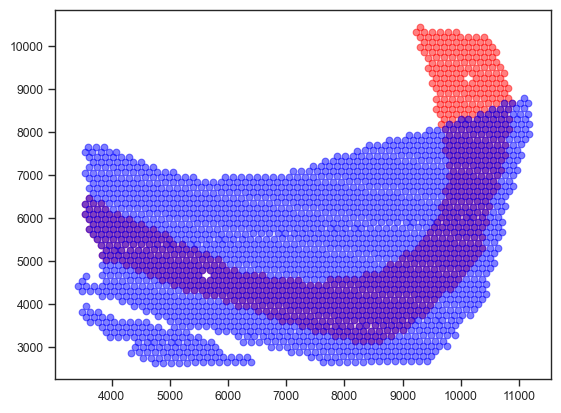

In [299]:
plt.scatter(spatial_gt[:, 0], spatial_gt[:, 1], color="red", label="ground truth", alpha=0.5)
plt.scatter(spatial_pesudo[:, 0], spatial_pesudo[:, 1], color="blue", label="pesudo", alpha=0.5)


In [302]:
matches = stutils.match_points_hungarian(spatial_pesudo, spatial_gt)
spatial_gt_matched = spatial_gt[matches[:, 1], :]

In [306]:
spatial_gt_matched.shape, spatial_pesudo.shape

((836, 2), (2009, 2))

In [303]:
affine_matrix = stutils.find_affine_transformation(spatial_pesudo, spatial_gt_matched)
spatial_affine = stutils.affine_transform(spatial_pesudo, affine_matrix)
spatial_pesudo.shape

LinAlgError: Incompatible dimensions

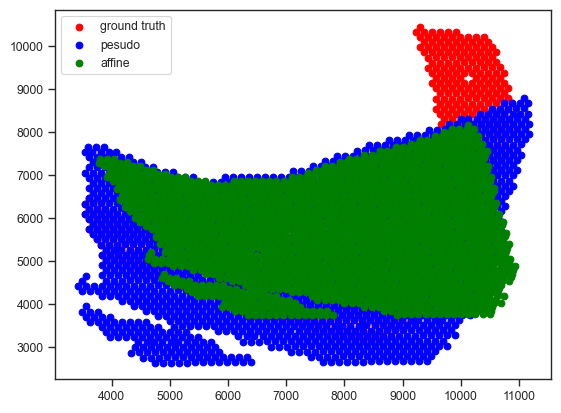

In [296]:
plt.scatter(spatial_gt[:, 0], spatial_gt[:, 1], color="red", label="ground truth")
plt.scatter(spatial_pesudo[:, 0], spatial_pesudo[:, 1], color="blue", label="pesudo")
plt.scatter(spatial_affine[:, 0], spatial_affine[:, 1], color="green", label="affine")
plt.legend()

In [201]:
new_spatial_affine = stutils.quantize_coordination(spatial_affine, methods=[("division", 125), ("division", 125)])

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.008, mean deviation: 0.24988609463902467, pearson correlation: 0.9998663779810861
Quantize 1th dimension of spatial coordinates to 0.008, mean deviation: 0.25119887769176147, pearson correlation: 0.9998512023407538


In [203]:
new_spatial_affine.max(axis=0), adata_ref.obsm["new_spatial"].max(axis=0)

(array([69., 68.]), array([64, 68], dtype=int64))

In [310]:
stadiff_sim

AnnData object with n_obs × n_vars = 3431 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'pesudo_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'spatial_net', 'pesudo_labels_colors', 'ground_truth_colors', 'edge_list', 'neighbors', 'umap'
    obsm: 'spatial', 'new_spatial', 'real_embed', 'latent', 'X_umap'
    obsp: 'distances', 'connectivities'

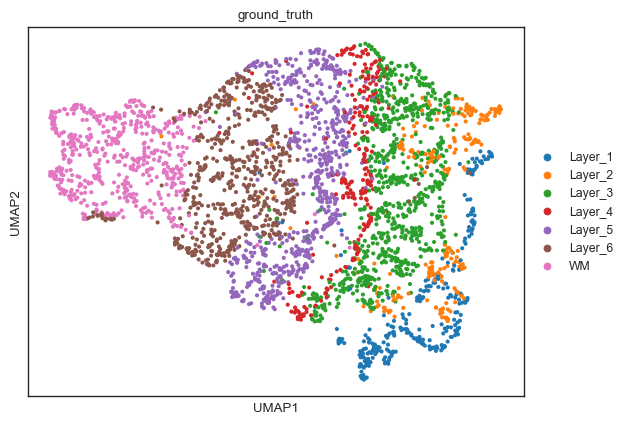

In [314]:
sc.pp.neighbors(stadiff_sim, use_rep="latent")
sc.tl.umap(stadiff_sim, min_dist=0.5)
sc.pl.embedding(stadiff_sim, basis="umap", color="ground_truth")

In [191]:
X_target = adata_target.X
X_target = X_target[matched_indices, :]
adata_pesudo_target = adata_ref.copy()
adata_pesudo_target.X = X_target
adata_pesudo_target.obs["ground_truth"] = adata_target.obs["ground_truth"].to_numpy()[matched_indices]

In [177]:
adata_target_recon = stutils.cal_spatial_net2D(adata_target, rad_cutoff=150, add_key="spatial_net", use_obsm="spatial")


6.853242

In [193]:
adata_pesudo_target_recon = get_recon(adata_pesudo_target, autoencoder_target, device=device, use_net="spatial_net", apply_normalize=False)

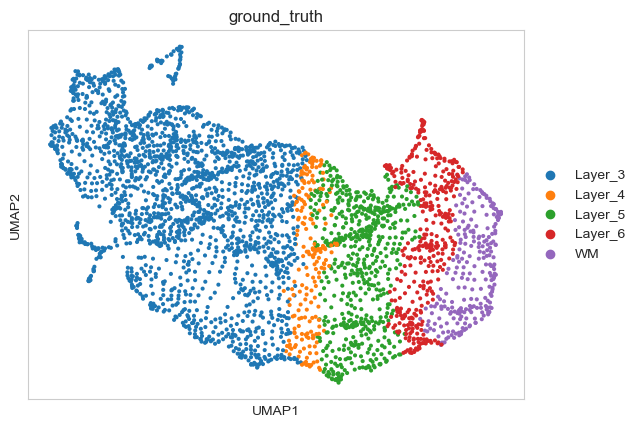

In [194]:
# perform umap
sc.pp.neighbors(adata_pesudo_target_recon, use_rep="latent", n_neighbors=30)
sc.tl.umap(adata_pesudo_target_recon)
sc.pl.embedding(adata_pesudo_target_recon, basis="umap", color="ground_truth")

In [195]:
# load the
srt_sim = read_adata_list("../output/App1-DLPFC/151676/redesign_151670/", "SRT_tissue_redesign_{}.rds",
                          1, ref_data=adata_pesudo_target_recon)[0]

In [198]:
srt_sim = get_recon(srt_sim, autoencoder, device=device, use_net="spatial_net")

In [215]:
stadiff_perf = compute_sim_perf([stadiff_sim], autoencoder_target, adata_pesudo_target_recon, adata_pesudo_target_recon,
                     enhanced = True,
                     n_rep=1)

In [216]:
srtsim_perf = compute_sim_perf([srt_sim], autoencoder_target, adata_pesudo_target_recon, adata_pesudo_target_recon,
                     enhanced = True,
                     n_rep=1)

In [274]:
sorted_ind = adata_target.X.mean(axis=0).argsort()[0, -100:][::-1]
sorted_ind = sorted_ind.tolist()[0]

In [275]:
from scipy.stats import pearsonr
stadiff_gene_corr = []
srt_gene_corr = []
for ind in sorted_ind:
    print(ind)
    stadiff_gene_corr.append(pearsonr(stadiff_sim.X[:, ind], adata_pesudo_target_recon.X[:, ind])[0])
    srt_gene_corr.append(pearsonr(srt_sim.X[:, ind], adata_pesudo_target_recon.X[:, ind])[0])

697
1029
923
2445
1332
2725
2754
2222
1680
1698
651
1099
298
994
62
545
65
1760
1151
2289
1084
1872
2406
1474
341
2215
1802
1784
2366
1553
2449
2380
173
795
273
2104
1269
158
199
252
1758
878
2629
1979
562
2518
1893
1452
1947
1383
1638
773
2145
2738
1351
1061
1480
1405
1755
2991
2288
695
1604
2778
2435
2868
1501
2468
1373
1186
1227
2243
484
1558
2828
187
1554
1440
1572
2802
231
1476
2995
2594
793
2997
530
710
2824
1331
1876
1043
1270
357
2620
2287
2996
2993
2992
2994


In [278]:
np.mean(stadiff_gene_corr), np.mean(srt_gene_corr)

(0.12532761556671734, 0.0638394373353038)

In [219]:
stadiff_mlisi = metrics.compute_paired_lisi(stadiff_sim,
                                            adata_pesudo_target_recon, use_rep="latent")

In [220]:
srtsim_mlisi = metrics.compute_paired_lisi(srt_sim,
                                            adata_pesudo_target_recon, use_rep="latent")

In [221]:
print("stadiff: {:.2f}".format(stadiff_mlisi.mean()))
print("srt: {:.2f}".format(srtsim_mlisi.mean()))

stadiff: 1.00
srt: 1.00


In [279]:
# perform umap on stadiff_sim
sc.pp.neighbors(stadiff_sim, use_rep="latent", n_neighbors=30)
sc.tl.umap(stadiff_sim)
sc.pl.embedding(stadiff_sim, basis="umap", color="pesudo_labels")

ValueError: Did not find latent in `.obsm.keys()`. You need to compute it first.

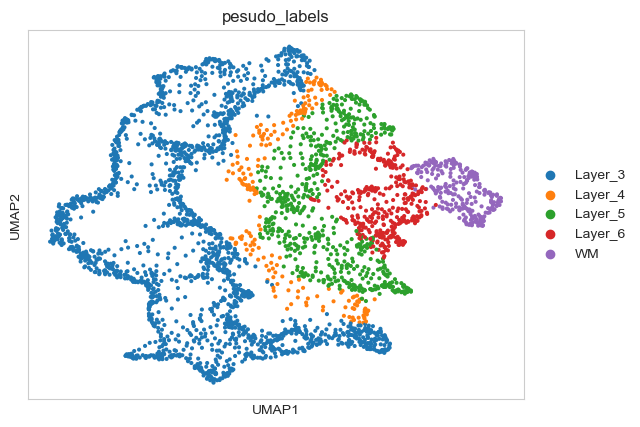

In [214]:
# perform umap on srt_sim
sc.pp.neighbors(srt_sim, use_rep="latent", n_neighbors=30)
sc.tl.umap(srt_sim)
sc.pl.embedding(srt_sim, basis="umap", color="pesudo_labels")